### Libraries

In [1]:
import os
import copy
import logging
import time
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import pytorch_lightning as pl
from torchvision.io import read_image
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
import cv2 as cv
from skimage.segmentation import slic
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score
from models import *
from aux_functions import *

# Explainability libraries
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import Occlusion
from captum.attr import GuidedGradCam
from captum.attr import LayerGradCam
from captum.attr import Lime
from captum.attr import ShapleyValueSampling
from captum.attr import DeepLift

import shap
from lime import lime_image
from omnixai.data.image import Image
from omnixai.explainers.vision import LimeImage

%matplotlib inline

/home/tachasam/miniconda3/envs/tachanew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-03 22:34:28.182172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 22:34:28.365216: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 22:34:28.950637: W tensorflow/compiler/xla/stream_executor/p

### Choose Device

In [2]:
# CHOOSE IF CPU, GPU 0 or GPU1
DEVICE_FLAG = '1' # 'cpu', '0', '1'

if DEVICE_FLAG == 'cpu':
    os.environ["CUDA_VISIBLE_DEVICES"]=""
    device = 'cpu'
elif DEVICE_FLAG == '0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    selected_gpu = 0
    device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
elif DEVICE_FLAG == '1':
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Variables

In [3]:
train_ratio= 0.8
root_dir = '../rsna22_bal/rsna22_bal/'
new_size = (1024, 512) # resnet50, vgg16, mobilenetv2 = 224, inception_v3 = 299
num_epochs = 25
train_model = False

### Prepare the train and val dataframes

Uncomment the cells according to the desired dataset to use for training:
- OMIDB Malignant and Benign subset for further training of the whole mammogram classification model
- Balanced RSNA22 subset for initial training of the whole mammogram classification model
- Iceberg Selection for training of the patch-based classification model

#### OMIDB Malignant and Benign Subset

In [4]:
root_dir = '../iceberg_selection/iceberg_selection/'

# READ CSVs
df_val = pd.read_csv(root_dir + 'combined_val.csv')
df_train = pd.read_csv(root_dir + 'combined_train.csv')

#### Balanced RSNA22 Subset

In [5]:
# # TRAIN DATAFRAME
# df_train = pd.read_csv(root_dir + 'train_bal.csv')
# df_train = df_train.rename(columns={df_train.columns[0]: 'index'})
# df_train.set_index('index', inplace=True)
# df_train['path'] = root_dir + 'images_png/' + df_train['filename'].str.split('/').str[-1]
# df_train['label'] = df_train['cancer']

# # VAL DATAFRAME
# df_val = pd.read_csv(root_dir + 'val_bal.csv')
# df_val = df_val.rename(columns={df_val.columns[0]: 'index'})
# df_val.set_index('index', inplace=True)
# df_val['path'] = root_dir + 'images_png/' + df_val['filename'].str.split('/').str[-1]
# df_val['label'] = df_val['cancer']

# # PRINT DF'S LENGTHS
# print(f'Train dataframe length: {len(df_train)}')
# print(f'Val dataframe length: {len(df_val)}')
# print(f'Total length: {len(df_train) + len(df_val)} \n')

# # PRINT NUMBER OF NEGATIVE AND POSITIVE CASES
# df_train_0 = df_train[df_train['label'] == 0]
# df_train_1 = df_train[df_train['label'] == 1]

# df_val_0 = df_val[df_val['label'] == 0]
# df_val_1 = df_val[df_val['label'] == 1]
# neg_to_pos_ratio = len(df_train_0)/len(df_train_1)
# print(f'Negative cases in train dataframe: {len(df_train_0)}')
# print(f'Positive cases in train dataframe: {len(df_train_1)}')
# print(f'Ratio Negative/Positive: {neg_to_pos_ratio}')

# print(f'Negative cases in val dataframe: {len(df_val_0)}')
# print(f'Positive cases in val dataframe: {len(df_val_1)}')

#### Iceberg Selection

In [6]:
# root_dir = '../iceberg_selection/iceberg_selection/'

# df = pd.read_csv(root_dir + 'omidb-selection.csv')

# # FFDM val dataframe
# df_val = df.iloc[:, [0,6,1,4,7,8]].copy()
# df_val['subtype'] = df_val['subtype'].astype(str)
# df_val['subtype'].replace('0', '000', inplace=True)
# df_val['subtype'].replace('1', '001', inplace=True)
# df_val['subtype'].replace('10', '010', inplace=True)
# df_val['subtype'].replace('11', '011', inplace=True)

# # SEPARATE CROP COORDINATES INTO DIFFERENT COLUMNS
# df_val['crop_x'] = df_val['bbox'].str[12:-1].str.split(',').str[0].str[3:]
# df_val['crop_y'] = df_val['bbox'].str[12:-1].str.split(',').str[1].str[4:]
# df_val = df_val.drop('bbox', axis=1)

# # SEPARATE BOUNDING BOX COORDINATES INTO DIFFERENT COLUMNS
# df_val['x1'] = df_val['bbox_roi'].str[12:-1].str.split(',').str[0].str[3:]
# df_val['y1'] = df_val['bbox_roi'].str[12:-1].str.split(',').str[1].str[4:]
# df_val['x2'] = df_val['bbox_roi'].str[12:-1].str.split(',').str[2].str[4:]
# df_val['y2'] = df_val['bbox_roi'].str[12:-1].str.split(',').str[3].str[4:]
# df_val = df_val.drop('bbox_roi', axis=1)

# # GET PATH AND LABEL
# df_val['path'] = root_dir + df_val['scanner'] + '/ffdm/' + 'st' + df_val['subtype'] + '/' + df_val['filename']
# df_val['label'] = '1'
# df_val = df_val.drop(df_val[df_val['scanner'] != 'HOLOGIC'].index)

# # GET THE HEIGHT AND WIDTH OF THE IMAGES
# shape_list_h = []
# shape_list_w = []
# for i in tqdm(range(len(df_val))):
#     imgpath = df_val['path'].iloc[i]
#     img = read_image(imgpath)
#     imgshape = img.shape[1:]
#     shape_list_h.append(imgshape[0])
#     shape_list_w.append(imgshape[1])

# df_val['height'] = shape_list_h
# df_val['width'] = shape_list_w
# df_val.head()    

# print('Length of val dataframe:', len(df_val))

### Transforms

Defining the transforms for the train and validation sets

In [7]:
transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.Resize(new_size),
            #transforms.ToTensor(),
            transforms.Normalize((0.2702), (0.1460))
        ])

transform_val = transforms.Compose([
            transforms.Resize(new_size),
            #transforms.ToTensor(),
            transforms.Normalize((0.2702), (0.1460))
        ])

### Custom Datasets

General Dataset for train and validation dataloaders

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.transform = transform
        self.dataframe = dataframe

        self.images = self.dataframe['path'].tolist()
        self.labels = self.dataframe['label'].astype(int).tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = read_image(img_path)
        image = image.float()
        image = self.transform(image)

        return {
            'image': image,
            'label': label
        }

train_data = CustomImageDataset(df_train, transform_train)
val_data = CustomImageDataset(df_val, transform_val)

Dataset used for computing the IOU of all the images in the validation set

In [9]:
class CustomImageDatasetExp(Dataset):
    def __init__(self, dataframe, transform):
        self.transform = transform
        self.dataframe = dataframe

        self.images = self.dataframe['path'].tolist()
        self.labels = self.dataframe['label'].astype(int).tolist()
        self.width = self.dataframe['width'].astype(int).tolist()
        self.height = self.dataframe['height'].astype(int).tolist()
        self.x1 = self.dataframe['x1'].astype(int).tolist()
        self.y1 = self.dataframe['y1'].astype(int).tolist()
        self.x2 = self.dataframe['x2'].astype(int).tolist()
        self.y2 = self.dataframe['y2'].astype(int).tolist()
        self.crop_x = self.dataframe['crop_x'].astype(int).tolist()
        self.crop_y = self.dataframe['crop_y'].astype(int).tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        width = self.width[idx]
        height = self.height[idx]
        x1 = self.x1[idx]
        y1 = self.y1[idx]
        x2 = self.x2[idx]
        y2 = self.y2[idx]
        crop_x = self.crop_x[idx]
        crop_y = self.crop_y[idx]
        
        image = read_image(img_path)
        image = image.float()
        image = self.transform(image)

        return {
            'image': image,
            'label': label,
            'width' : width,
            'height' : height,
            'x1' : x1,
            'y1' : y1,
            'x2' : x2,
            'y2' : y2,
            'crop_x': crop_x,
            'crop_y': crop_y
        }

### Dataloaders

Train and validation dataloaders

In [10]:
# CREATE DATALOADERS
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False)
dataloaders =  {'train': train_dataloader,
                'val': val_dataloader}

# DATASET SIZES
dataset_sizes = {'train': len(train_data),
                 'val': len(val_data)}

### TRAIN NETWORK

In [11]:
if train_model == True:
    ### Define network
    model = make_efficientnetb0_2(model_name='./best_model_efficientnetb0_full_1024_2.pth', pretrained=False)
    model.to(device)

    # DEFINE LOSS FUNCTION AND OPTIMIZER
    # pos_weight = torch.Tensor([3.0]).to(device)
    # criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    #optimizer =torch.optim.Adam(model.parameters(), lr=0.0001)
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # MODEL SUMMARY
    # from torchsummary import summary
    # summary(model, (3,224,224))
    ### Training
    writer_path = f'/home/tachasam/Tensorboard/Full/{model.name}_1024_RSNA_OMIDB_crop'
    checkpoint_path = f'/home/tachasam/Tensorboard/checkpoints/{model.name}_full_1024_RSNA_OMIDB_crop.pth'
    early_stop_patience=10

    since = time.time()

    writers = {
            'train': SummaryWriter(writer_path + '/log'),
            'val': SummaryWriter(writer_path + '/log_val')
        }

    best_model_wts = copy.deepcopy(model.state_dict()) # initialize best weights with initial model weights
    best_loss = 1e8 # as bad as it gets 
    best_acc = 0.0 # as bad as it gets 
    best_kappa = 0.0 # as bad as it gets 
    early_stop_c = 0 # initialize early stopping count
    prev_epoch = -1

    for epoch in range(prev_epoch+1, num_epochs): # iterate over the whole dataset (epoch)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 15)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']: 
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 # keep track of epoch loss
            running_labels = [] # list to hold labels over all the epoch
            running_preds = [] # list to hold the model predictions over all the epoch

            # Iterate over data
            for batch in tqdm(dataloaders[phase]): # iterate over each batch in the loader
                inputs = batch["image"].to(device) # fetch data and move to GPU/CPU
                labels = batch["label"].to(device) # fetch data and move to GPU/CPU

                # Concatenate the grayscale image with itself to create a 3-channel image
                inputs = torch.cat((inputs, inputs, inputs), dim=1)
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # -- Forward --
                # Track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # forward pass 
                    # labels = labels.unsqueeze(1) 
                    # labels = labels.float() 
                    # outputs_sig = torch.sigmoid(outputs)
                    # preds = ((outputs_sig>0.5)*1).float()  # get the label
                    _, preds = torch.max(outputs.detach(), 1)
                    loss = criterion(outputs, labels) # calculate the loss of the batch

                    # -- Backward + optimize only if in training phase --
                    if phase == 'train':
                        loss.backward() # backpropagation
                        optimizer.step() # update weights 
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_labels = running_labels + labels.int().cpu().tolist()
                running_preds = running_preds + preds.int().cpu().tolist()
            
            print('\n preds:', running_preds, '\n labs:', running_labels)
            epoch_loss = running_loss / dataset_sizes[phase] # average loss of the epoch
            epoch_acc = accuracy_score(running_labels, running_preds) # accuracy of the epoch
            epoch_kappa = cohen_kappa_score(running_labels, running_preds) # kappa of the epoch

            if phase == 'val':
                scheduler.step(epoch_loss) # update LR dynamically 
                lr_ = optimizer.param_groups[0]['lr'] # save current learning rate to writer
                writers['train'].add_scalar('info/lr', lr_, epoch)

            logging.info( '%s epoch %d : loss : %.4f, acc: %.4f, kappa: %.4f' %
                (phase, epoch+1, epoch_loss, epoch_acc, epoch_kappa))
            
            # Save stats to writer for tracking
            writers[phase].add_scalar('info/loss', epoch_loss, epoch)
            writers[phase].add_scalar('info/acc', epoch_acc, epoch)
            writers[phase].add_scalar('info/kappa', epoch_kappa, epoch)

            print(f'{phase} loss: {epoch_loss}')
            print(f'{phase} acc: {epoch_acc}')
            print(f'{phase} kappa: {epoch_kappa}')


            # Update best parameters
            if phase == 'val':
                if epoch_loss < best_loss:  # a new best val loss achieved 
                    best_loss = epoch_loss  # update the best loss
                    early_stop_c = 0  # new minimum found, reset ES counter
                    best_model_wts = copy.deepcopy(model.state_dict()) # update best weights tracker
                    torch.save(best_model_wts, f"best_model_{model.name}_full_1024_RSNA_OMIDB_crop.pth")
                else:
                    early_stop_c += 1  # increment ES counter

                if epoch_kappa > best_kappa: # a new best val kappa score achieved 
                    best_kappa = epoch_kappa # update the best kappa

                if epoch_acc > best_acc: # new best accuracy achieved
                    best_acc = epoch_acc  # update accuracy tracker

        torch.save({
            'model_state': model.state_dict(),
            'criterion': criterion,
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'epoch': epoch,
            'best_loss': best_loss,
            'best_acc': best_acc,
            'best_kappa': best_kappa,
            'early_stop_c': early_stop_c
            }, checkpoint_path)

        if early_stop_c > early_stop_patience: # if no val loss minimum was found in the last ES Patience epochs then stop training
            print(f'EARLY STOP AFTER {epoch + 1} EPOCHS')         
            break   

        print()

    # Print statistics 
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')
    print(f"Best val acc: {best_acc}")
    #print(f"Best val kappa: {best_kappa}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    writers['train'].close()
    writers['val'].close()

### Predictions

##### 1 output neuron

Compute predictions for the validation set if your model has one output neuron

In [ ]:
# LOAD MODEL
model = make_efficientnetb3(model_name='./best_model_efficientnetb3_full_1024.pth', pretrained=False)
model.to(device)
model.eval()

# TO STORE THE LABELS, PREDICTIONS AND PROBABILITIES
running_labels = []
running_preds = []
running_probs = []

# ITERATE OVER DATA
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)

        inputs = torch.cat((inputs, inputs, inputs), dim=1)
        outputs = model(inputs)
        outputs_sig = torch.sigmoid(outputs)
        preds = ((outputs_sig>0.5)*1).float()
        
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
        running_probs.append(outputs_sig.cpu().numpy())

# STORE PREDICTIONS IN DIFFERENT SHAPE
running_preds_2 = []
for i in range(len(running_preds)):
    running_preds_2.append(running_preds[i][0])

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  0%|          | 0/226 [00:00<?, ?it/s]

##### 2 output neurons

Compute the predictions for the validation set if your model has 2 output neurons

In [12]:
# LOAD MODEL
model = make_efficientnetb0_2(model_name='./best_model_efficientnetb0_full_1024_RSNA_OMIDB_crop.pth', pretrained=False) # Choose model and load weights
model.to(device)
model.eval()

# TO STORE THE LABELS, PREDICTIONS AND PROBABILITIES
running_labels = []
running_preds = []
running_probs_neg = []
running_probs_pos = []

# ITERATE OVER DATA
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)

        inputs = torch.cat((inputs, inputs, inputs), dim=1)
        outputs = model(inputs)
        outputs_sig = torch.sigmoid(outputs)
        # probs_neg = outputs_sig[0].cpu().numpy()
        # probs_pos = outputs_sig[1].cpu().numpy()
        probs_neg = outputs_sig[:,0].cpu().tolist()
        probs_pos = outputs_sig[:,1].cpu().tolist()
        # preds = ((outputs_sig>0.5)*1).float()
        _, preds = torch.max(outputs_sig.detach(), 1)

        running_labels      = running_labels + labels.int().cpu().tolist()
        running_preds       = running_preds + preds.int().cpu().tolist()
        running_probs_neg   = running_probs_neg + probs_neg
        running_probs_pos   = running_probs_pos + probs_pos

# STORE PREDICTIONS IN DIFFERENT SHAPE
running_preds_2 = running_preds
running_probs = running_probs_pos

# PROBS FOR DF
both_probs = np.column_stack((running_probs_neg, running_probs_pos))
both_probs = np.max(both_probs, axis=1)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


In [13]:
# PRINT PREDICTIONS AND LABELS
print(f'Predictions: {running_preds_2}')
print(f'Labels: {running_labels}')

# COMPUTE AUC
my_auc = roc_auc_score(running_labels, running_probs)
print(f'AUC Score: {my_auc}')

Predictions: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,

### Visualize predictions

(1441,)
(1441, 1)


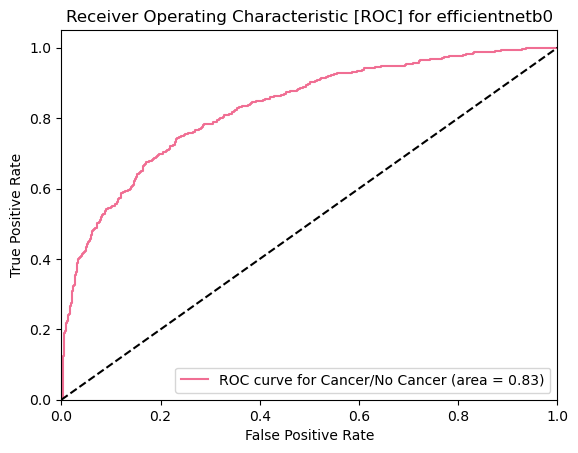

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix of the model'}, xlabel='Predicted label', ylabel='True label'>

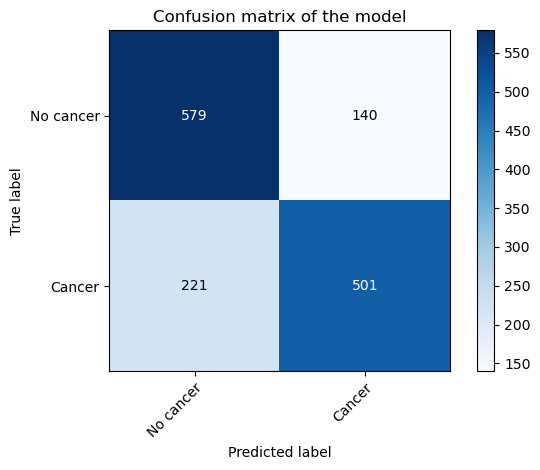

In [14]:
probs = np.vstack(running_probs)
plot_roc(running_labels, probs, True, model.name, n_classes=1)
plot_confusion_matrix(running_labels, running_preds_2, ['No cancer', 'Cancer'],
                          normalize=False,
                          title='Confusion matrix of the model',
                          cmap=plt.cm.Blues)

#### Getting TPs and TNs

In [ ]:
omidb = True #set to true if working with OMIDB malignant and benign subset for obtaining bounding box gt values

In [16]:
# PROBS IS 2D SO WE FLATTEN IT FOR DF
probs_list = probs.flatten() # (comment from flatten when working with OMIDB)

# CREATE DATAFRAME WITH PREDICTIONS, LABELS AND PROBABILITIES
preds_dict = {'prediction': running_preds_2,
              'label': running_labels,
              'probability': probs_list}
df_preds = pd.DataFrame(preds_dict)

# GET PATHS, IMAGES SHAPE, AND BBOX COORDINATES FROM DF_VAL
df_preds['path'] = df_val['path'].values

if omidb == True:
    df_preds['height'] = df_val['height'].values
    df_preds['width'] = df_val['width'].values
    df_preds['x1'] = df_val['x1'].values
    df_preds['y1'] = df_val['y1'].values
    df_preds['x2'] = df_val['x2'].values
    df_preds['y2'] = df_val['y2'].values
    df_preds['crop_x'] = df_val['crop_x'].values
    df_preds['crop_y'] = df_val['crop_y'].values

# CREATE TN & TP DATAFRAMES
df_tn = df_preds[(df_preds['prediction'] == 0) & (df_preds['label'] == 0)]
df_tp = df_preds[(df_preds['prediction'] == 1) & (df_preds['label'] == 1)]
df_fn = df_preds[(df_preds['prediction'] == 0) & (df_preds['label'] == 1)]

# SORTED TN AND TP DATAFRAMES
df_tn_sorted = df_tn.sort_values(by=['probability'], ascending=True)
df_tp_sorted = df_tp.sort_values(by=['probability'], ascending=False)
df_fn_sorted = df_fn.sort_values(by=['probability'], ascending=False)
df_tp_sorted

prediction  label  probability  \
879            1      1     0.928077   
865            1      1     0.925863   
730            1      1     0.924241   
817            1      1     0.923471   
1108           1      1     0.921957   
...          ...    ...          ...   
954            1      1     0.502690   
1219           1      1     0.502184   
1036           1      1     0.500449   
920            1      1     0.494725   
1367           1      1     0.494677   

                                                   path  height   width  \
879   ../iceberg_selection/iceberg_selection/HOLOGIC...  3120.0  1778.0   
865   ../iceberg_selection/iceberg_selection/HOLOGIC...  2911.0  1280.0   
730   ../iceberg_selection/iceberg_selection/HOLOGIC...  2259.0  1315.0   
817   ../iceberg_selection/iceberg_selection/HOLOGIC...  3002.0  2059.0   
1108  ../iceberg_selection/iceberg_selection/HOLOGIC...  3141.0  1638.0   
...                                                 ...     ...     ...   
954   ../iceberg_selection/iceberg_selection/HOLOGIC...  3189.0  1422.0   
1219  ../iceberg_selection/iceberg_selection/HOLOGIC...  3111.0  1603.0   
1036  ../iceberg_selection/iceberg_selection/HOLOGIC...  2841.0  1856.0   
920   ../iceberg_selection/iceberg_selection/HOLOGIC...  3102.0  1466.0   
1367  ../iceberg_selection/iceberg_selection/HOLOGIC...  3319.0  1483.0   

         x1      y1      x2      y2  crop_x  crop_y  
879   727.0   836.0   938.0  1091.0     0.0    12.0  
865   324.0  1906.0   855.0  2447.0     0.0   446.0  
730   121.0  1147.0   382.0  1408.0     0.0   342.0  
817   774.0  1612.0  1221.0  2037.0     0.0    24.0  
1108  295.0  1292.0   784.0  1781.0     0.0    12.0  
...     ...     ...     ...     ...     ...     ...  
954   658.0  1646.0   874.0  1846.0     0.0     0.0  
1219  345.0  2506.0   475.0  2648.0     0.0   217.0  
1036  653.0  1945.0  1200.0  2239.0     0.0   198.0  
920    52.0  1008.0   262.0  1203.0     0.0   226.0  
1367  144.0  2079.0   314.0  2236.0     0.0     9.0  

[501 rows x 12 columns]

### CAPTUM EXPLAINABILITY

#### Get labels/predictions from DF

In [18]:
# Change to df_tp_sorted or df_tn_sorted for true positives and true negatives
df_sorted = df_tp_sorted

#### Compute IOU for all

In [29]:
# Select explainability method to compute for all
method = 'dl' # 'sal', 'ig', 'occ', 'gc', 'lime', 'shap', 'dl'

model.eval()
exp_data = CustomImageDatasetExp(df_sorted, transform_val)
exp_dataloader = DataLoader(exp_data, batch_size=10, shuffle=False)

iou_final = []
iterator = 1
with torch.no_grad():
    for batch in exp_dataloader:
        print(f'Loop {iterator}/{len(exp_dataloader)}')
        imgs_exp = batch["image"]
        lbls_exp = batch["label"]
        width = batch["width"]
        height = batch["height"]
        x1 = batch["x1"]
        y1 = batch["y1"]
        x2 = batch["x2"]
        y2 = batch["y2"]
        crop_x = batch["crop_x"]
        crop_y = batch["crop_y"]

        # PREPARE THE INPUT FOR EXPLAINABILITY MODELS
        input = imgs_exp
        input = input.to(device)
        input = torch.cat((input, input, input), dim=1)
        input.requires_grad = True

        # RESHAPE IMAGES TO (Batch, H, W)
        np_imgs_exp = np.reshape(imgs_exp, (len(imgs_exp),1024,512))

        ######## GROUND TRUTH BOUNDING BOXES
        x1_new = x1 - crop_x
        y1_new = y1 - crop_y
        x2_new = x2 - crop_x
        y2_new = y2 - crop_y
        bbox_list_gt = [(x1_new*new_size[1]/width), y1_new*new_size[0]/height, x2_new*new_size[1]/width, y2_new*new_size[0]/height]
        bbox_list_gt = [[int(element) for element in sublist] for sublist in zip(*bbox_list_gt)]

        ######### EXPLAINABILITY #######
        # Saliency
        if method == 'sal':
            saliency = Saliency(model)
            attributions_list = []
            for i in tqdm(range(len(input))):
                input_i = input[i].unsqueeze(0)
                input_i.requires_grad = True
                attributions_sal = saliency.attribute(input_i, target=1)
                attributions_sal = attributions_sal.squeeze(0).cpu().detach().numpy()
                attributions_list.append(attributions_sal)

        # DeepLIFT
        elif method == 'dl':
            dl = DeepLift(model)
            attributions_list = []
            for i in tqdm(range(len(input))):
                input_i = input[i].unsqueeze(0)
                input_i.requires_grad = True
                attributions_dl = dl.attribute(input_i, target=1)
                attributions_dl = attributions_dl.squeeze(0).cpu().detach().numpy()
                attributions_list.append(attributions_dl)
        
        # Integrated Gradients
        elif method == 'ig':
            integrated_gradients = IntegratedGradients(model)
            attributions_list = []
            for i in tqdm(range(len(input))):
                attributions_ig = integrated_gradients.attribute(input[i].unsqueeze(0), target=1, n_steps=50)
                attributions_ig = attributions_ig.squeeze(0).cpu().detach().numpy()
                attributions_list.append(attributions_ig)
        
        # Occlusion
        elif method == 'occ':
            occlusion = Occlusion(model)
            attributions_list = []
            for i in tqdm(range(len(input))):
                attributions_occ = occlusion.attribute(input[i].unsqueeze(0),
                                                        strides = (3, 30, 30),
                                                        target=1,
                                                        sliding_window_shapes=(3, 60, 60),
                                                        baselines=0)
                attributions_occ = attributions_occ.squeeze(0).cpu().detach().numpy()
                attributions_list.append(attributions_occ)

        # Guided GradCAM
        elif method == 'gc':
            gradcam = GuidedGradCam(model, model.features[8])
            attributions_list = []
            for i in tqdm(range(len(input))):
                input_i = input[i].unsqueeze(0)
                input_i.requires_grad = True
                attributions_gc = gradcam.attribute(input_i, target=1)
                attributions_gc = attributions_gc.squeeze(0).cpu().detach().numpy()
                attributions_list.append(attributions_gc)

        # LIME
        elif method == 'lime':
            # Segment images for lime
            input_array = input.cpu().detach().numpy().transpose(0,2,3,1)
            mask_list = []
            for i in range(input_array.shape[0]):
                mask = slic(input_array[i], n_segments=150, compactness=10)
                mask = mask - 1
                mask = torch.tensor(mask)
                mask_list.append(mask)
            mask_list = [mask.to(device) for tensor in mask_list]

            # Compute lime
            lime = Lime(model)
            attributions_list = []
            for i in tqdm(range(len(input))):
                attributions_lime = lime.attribute(input[i].unsqueeze(0),
                                                feature_mask=mask_list[i],
                                                target=1,
                                                n_samples=200)
                attributions_lime = attributions_lime.squeeze(0).cpu().detach().numpy()
                attributions_list.append(attributions_lime)
        
        # SHAP
        elif method == 'shap':
            # Segment images
            input_array = input.cpu().detach().numpy().transpose(0,2,3,1)
            mask_list = []
            for i in range(input_array.shape[0]):
                mask = slic(input_array[i], n_segments=150, compactness=10)
                mask = mask - 1
                mask = torch.tensor(mask)
                mask_list.append(mask)
            mask_list = [mask.to(device) for tensor in mask_list]
            
            # Compute SHAP
            svs = ShapleyValueSampling(model)
            attributions_list = []
            for i in tqdm(range(len(input))):
                attributions_svs = svs.attribute(input[i].unsqueeze(0),
                                                feature_mask=mask_list[i],
                                                target=1,
                                                show_progress=True)
                attributions_svs = attributions_svs.squeeze(0).cpu().detach().numpy()
                attributions_list.append(attributions_svs)
        

        # SHOWING THE RESULTS
        # show_attributions(attributions_list, np_imgs_exp, lbls_exp, [1,1,1,1,1,1,1,1,1,1], cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='Occlusion')

        # Dilating results so they're more visible
        attributions_list_dilated = dilate_attributions(attributions_list)

        ############## BOUNDING BOXES ####################
        # Binarize the attributions, find the bounding boxes, combine them into one for each image
        if (method == 'lime') or (method == 'shap') or (method == 'occ'):
            binarized_attr = binarize_attributions(attributions_list, 0.98)
        else:
            binarized_attr = binarize_attributions(attributions_list_dilated, 0.96)

        bbox = attr_bbox(binarized_attr)
        bbox_combined = combine_bbox(bbox)
        # img_bbox_combined = draw_bbox(bbox_combined, np_imgs_exp)
        # show_bbox(img_bbox_combined, np_imgs_exp, lbls_exp, [1,1,1,1,1,1,1,1,1,1], alpha_map=0.9, alpha_img=0.6, title='Occlusion Bounding Boxes Combined')

        ############## COMPUTE IOU #######################
        iou_running = []
        for i in range(len(bbox_combined)):
            iou = calculate_iou(bbox_combined[i], bbox_list_gt[i])
            iou_running.append(iou)
        iou_final.extend(iou_running)

        iterator += 1
        print('-------------------------')


Loop 1/51


  0%|          | 0/10 [00:00<?, ?it/s]Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
100%|██████████| 10/10 [00:00<00:00, 25.02it/s]


-------------------------
Loop 2/51


100%|██████████| 10/10 [00:00<00:00, 26.02it/s]


-------------------------
Loop 3/51


100%|██████████| 10/10 [00:00<00:00, 26.85it/s]


-------------------------
Loop 4/51


100%|██████████| 10/10 [00:00<00:00, 27.61it/s]


-------------------------
Loop 5/51


100%|██████████| 10/10 [00:00<00:00, 26.46it/s]


-------------------------
Loop 6/51


100%|██████████| 10/10 [00:00<00:00, 27.10it/s]


-------------------------
Loop 7/51


100%|██████████| 10/10 [00:00<00:00, 26.67it/s]


-------------------------
Loop 8/51


100%|██████████| 10/10 [00:00<00:00, 26.59it/s]


KeyboardInterrupt: 

Uncomment the following cell to add another column to the df with the IOU scores for a method. Change the name of the column with the name of the method.

In [ ]:
# df_scores = pd.DataFrame(iou_final, columns=['IOU DL'])
# df_scores

# df_iou = pd.read_csv('iou_scores.csv')
# df_iou['IOU DL'] = df_scores['IOU DL']
# df_iou.to_csv('iou_scores.csv', index=False)
# df_iou

#### Plot IOU vs TPR

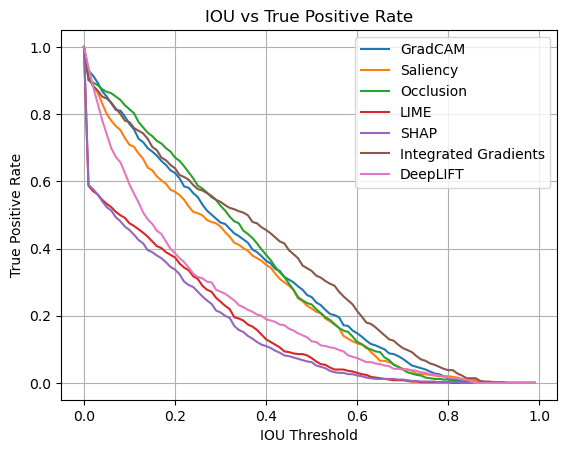

In [ ]:
df_iou = pd.read_csv('iou_scores.csv')

# Getting the true positive rate from each method
tpr_gc = get_tpr(df_iou['IOU GradCAM'].tolist())
tpr_sal = get_tpr(df_iou['IOU Saliency'].tolist())
tpr_occ = get_tpr(df_iou['IOU Occlusion'].tolist())
tpr_lime = get_tpr(df_iou['IOU Lime'].tolist())
tpr_shap = get_tpr(df_iou['IOU SHAP'].tolist())
tpr_ig = get_tpr(df_iou['IOU IG'].tolist())
tpr_dl = get_tpr(df_iou['IOU DL'].tolist())

# Plotting the graph
iou_thresholds = np.arange(0,1,0.01)
plt.plot(iou_thresholds, tpr_gc, label='GradCAM')
plt.plot(iou_thresholds, tpr_sal, label='Saliency')
plt.plot(iou_thresholds, tpr_occ, label='Occlusion')
plt.plot(iou_thresholds, tpr_lime, label='LIME')
plt.plot(iou_thresholds, tpr_shap, label='SHAP')
plt.plot(iou_thresholds, tpr_ig, label='Integrated Gradients')
plt.plot(iou_thresholds, tpr_dl, label='DeepLIFT')

plt.xlabel('IOU Threshold')
plt.ylabel('True Positive Rate')
plt.title('IOU vs True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

##### Plot Boxplots

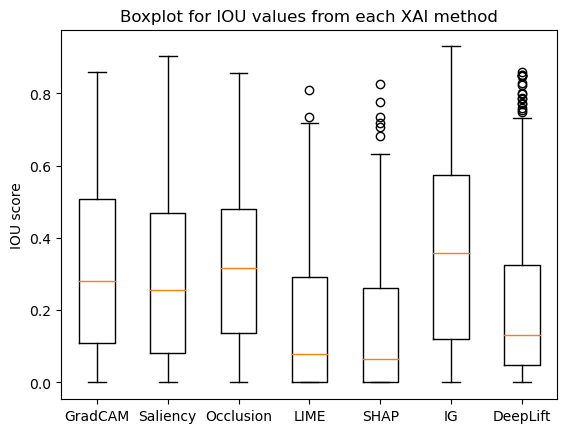

In [36]:
fig1, ax1= plt.subplots()
ax1.set_title('Boxplot for IOU values from each XAI method')
ax1.boxplot(df_iou.iloc[:,1:])
ax1.set_ylabel('IOU score')
ax1.set_xticks([1,2,3,4,5,6,7], ('GradCAM', 'Saliency', 'Occlusion', 'LIME', 'SHAP', 'IG', 'DeepLift'))

#### Get only 10 images to compute the attributions for

In [37]:
model.eval()

exp_data = CustomImageDataset(df_sorted, transform_val)
exp_dataloader = DataLoader(exp_data, batch_size=10, shuffle=False)
dataiter = iter(exp_dataloader)
batch_exp = next(dataiter)

# SEPARATE THE IMGS AND LABELS
imgs_exp = batch_exp['image']
lbls_exp = batch_exp['label']

# GET THE PREDICTIONS FROM THE DATAFRAME
preds_exp = df_sorted['prediction'].values
preds_exp = np.array(preds_exp[:10])

# PREPARE THE INPUT FOR EXPLAINABILITY MODELS
input = imgs_exp
input = input.to(device)
input = torch.cat((input, input, input), dim=1)
print('Inputs shape: ', input.shape)
input.requires_grad = True

# TURN PREDICTIONS INTO LIST
pred_label_idxs = []
for i in range(len(input)):
    pred_label_idxs.append(preds_exp[i])
preds_exp = torch.tensor(preds_exp)

# RESHAPE IMAGES TO (Batch, H, W)
print('Images shape before: ', imgs_exp.shape)
np_imgs_exp = np.reshape(imgs_exp, (10,1024,512))
print('Images shape after:', np_imgs_exp.shape)

Inputs shape:  torch.Size([10, 3, 1024, 512])
Images shape before:  torch.Size([10, 1, 1024, 512])
Images shape after: torch.Size([10, 1024, 512])


#### Show original images and ground truth bounding boxes

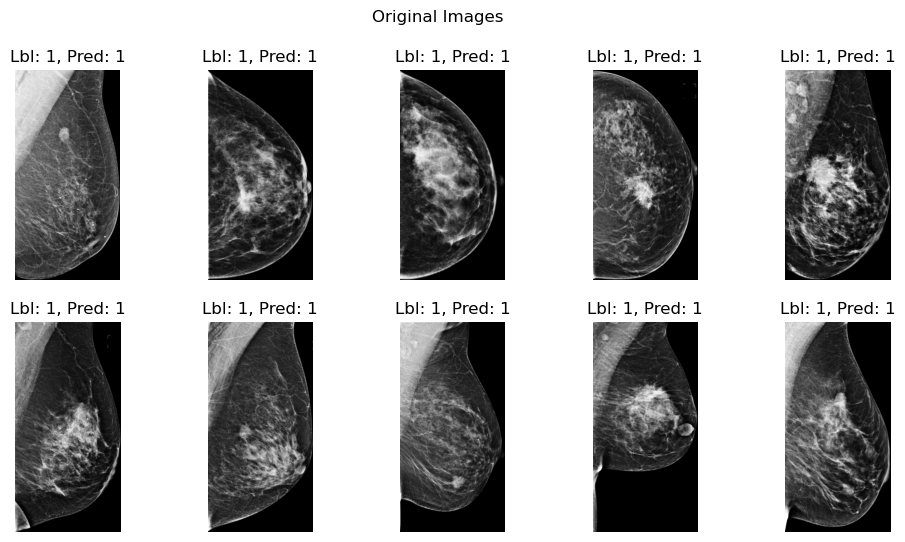

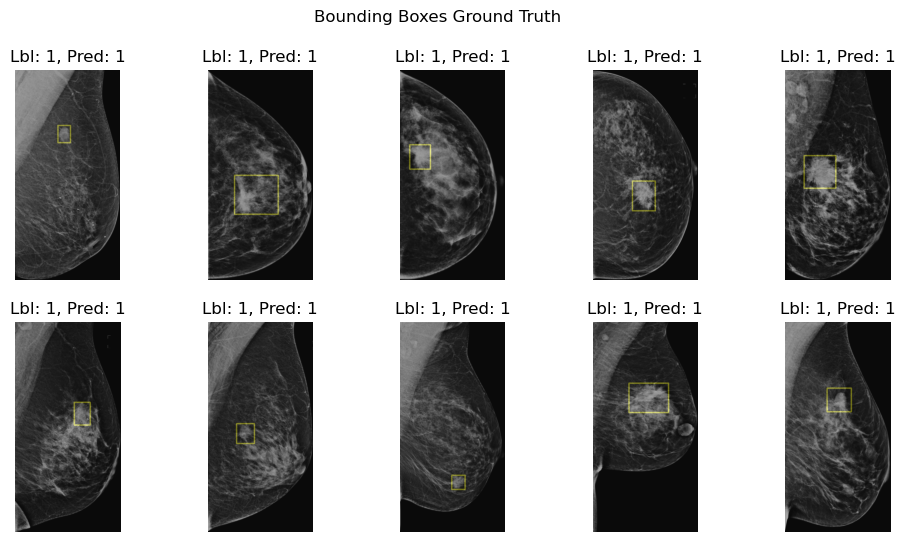

In [42]:
####### SHOW IMAGES
fig, axs = plt.subplots(2,5, figsize=(12,6))
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(np_imgs_exp[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Lbl: {lbls_exp[i]}, Pred: {preds_exp[i]}')
fig.suptitle('Original Images')

######### GROUND TRUTH BOUNDING BOXES
bbox_list_gt = []
for i in range(len(np_imgs_exp)):
    width = df_sorted['width'].iloc[i]
    height = df_sorted['height'].iloc[i]
    x1 = int(df_sorted['x1'].iloc[i]) - int(df_sorted['crop_x'].iloc[i])
    y1 = int(df_sorted['y1'].iloc[i]) - int(df_sorted['crop_y'].iloc[i])
    x2 = int(df_sorted['x2'].iloc[i]) - int(df_sorted['crop_x'].iloc[i])
    y2 = int(df_sorted['y2'].iloc[i]) - int(df_sorted['crop_y'].iloc[i])
    bbox_list_gt.append([int(x1*new_size[1]/width), int(y1*new_size[0]/height), int(x2*new_size[1]/width), int(y2*new_size[0]/height)])

# DRAW AND VISUALIZE THE BOUNDING BOXES
img_bbox_list_gt = draw_bbox(bbox_list_gt, np_imgs_exp, (255,255,0))
show_bbox(img_bbox_list_gt, np_imgs_exp, lbls_exp, pred_label_idxs, alpha_map=0.9, alpha_img=0.6, title='Bounding Boxes Ground Truth')

#### Saliency

100%|██████████| 10/10 [00:00<00:00, 24.86it/s]


[0.6002811621368322,
 0.16995412844036697,
 0.48043206011271133,
 0.5070163872669052,
 0.11742190215082828,
 0.22865168539325842,
 0.1368656643798959,
 0.04590395480225989,
 0.43100459510772365,
 0.47597990660817885]

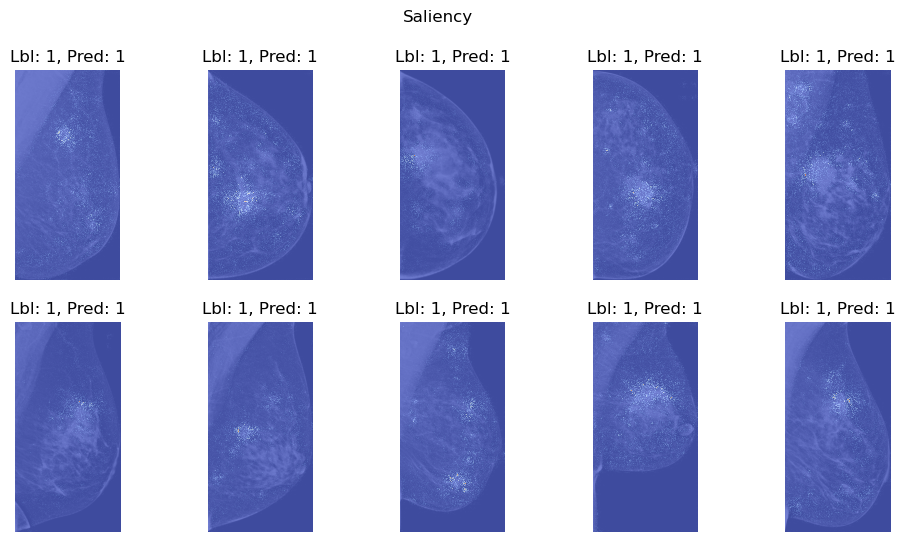

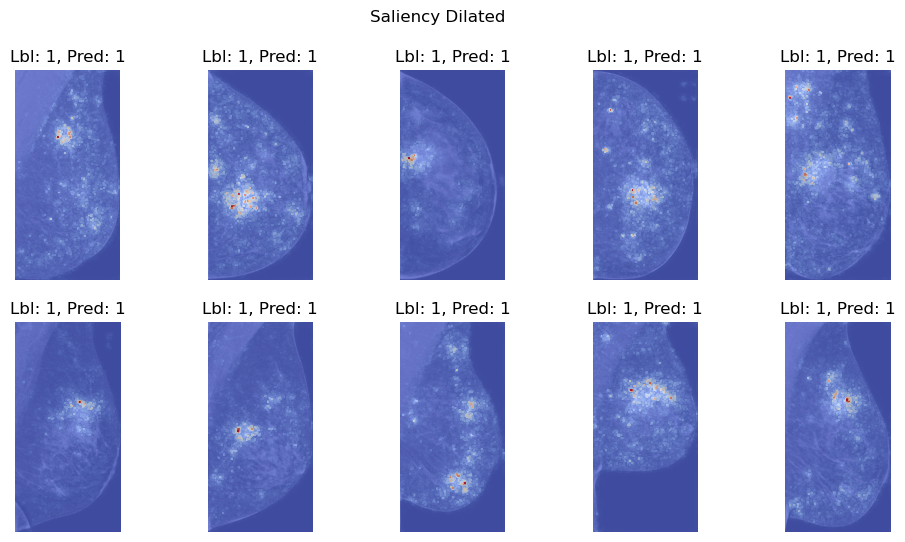

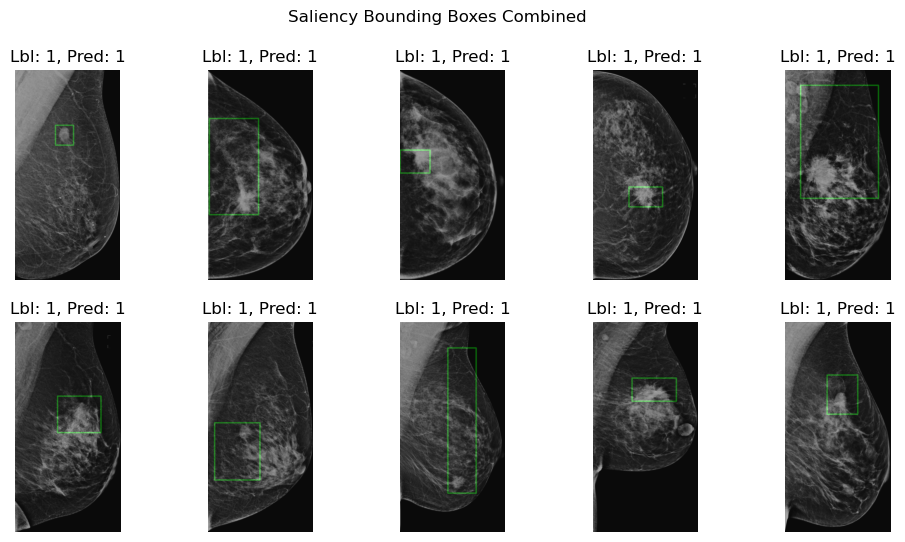

In [48]:
############## COMPUTE ATTRIBUTIONS ################
saliency = Saliency(model)
attributions_sal_list = []
for i in tqdm(range(len(input))):
    attributions_sal = saliency.attribute(input[i].unsqueeze(0), target=1)
    attributions_sal = attributions_sal.squeeze(0).cpu().detach().numpy()
    attributions_sal_list.append(attributions_sal)

# Dilating results so they're more visible
attributions_sal_list_dilated = dilate_attributions(attributions_sal_list)

# Showing results
show_attributions(attributions_sal_list, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='Saliency')
show_attributions(attributions_sal_list_dilated, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='Saliency Dilated')

############## BOUNDING BOXES ####################
# Binarize the attributions, find the bounding boxes, combine them into one for
# each image and draw them
binarized_attr_sal =    binarize_attributions(attributions_sal_list_dilated)
bbox_sal =              attr_bbox(binarized_attr_sal)
bbox_sal_combined =     combine_bbox(bbox_sal)
img_bbox_sal_combined = draw_bbox(bbox_sal_combined, np_imgs_exp)
show_bbox(img_bbox_sal_combined, np_imgs_exp, lbls_exp, pred_label_idxs, alpha_map=0.9, alpha_img=0.6, title='Saliency Bounding Boxes Combined')

############## COMPUTE IOU #######################
iou_sal = []
for i in range(len(bbox_sal_combined)):
    iou = calculate_iou(bbox_sal_combined[i], bbox_list_gt[i])
    iou_sal.append(iou)

print('IOU Scores: ')
print(iou_sal)

#### Integrated Gradients

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:08<00:00, 18.88s/it]


NameError: name 'bbox_list_gt' is not defined

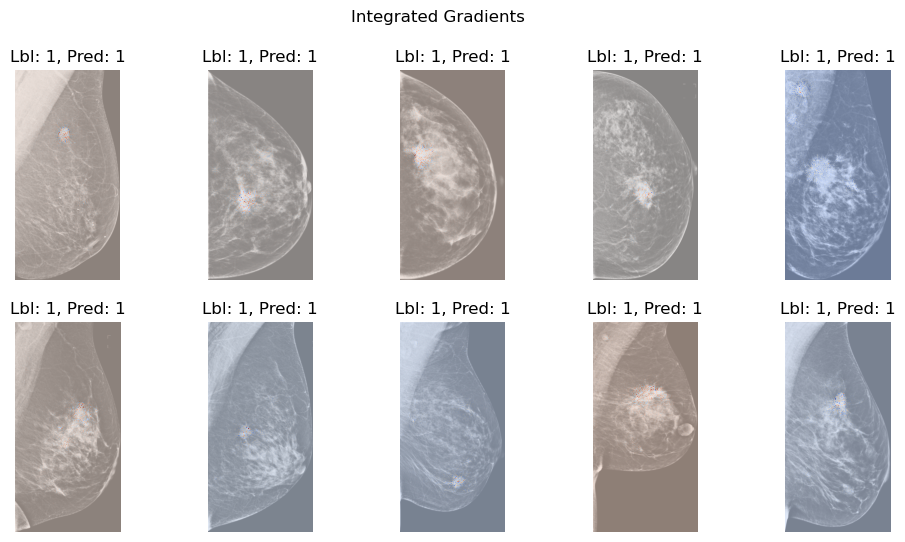

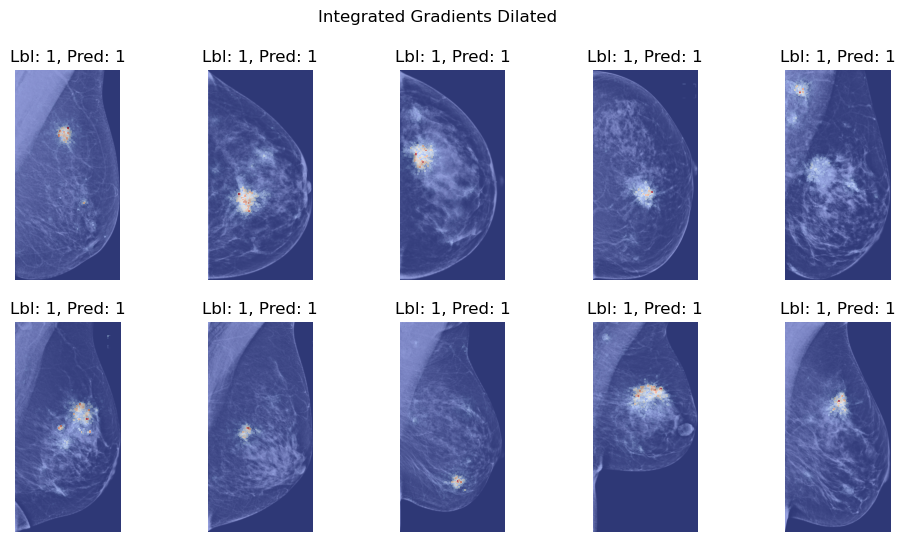

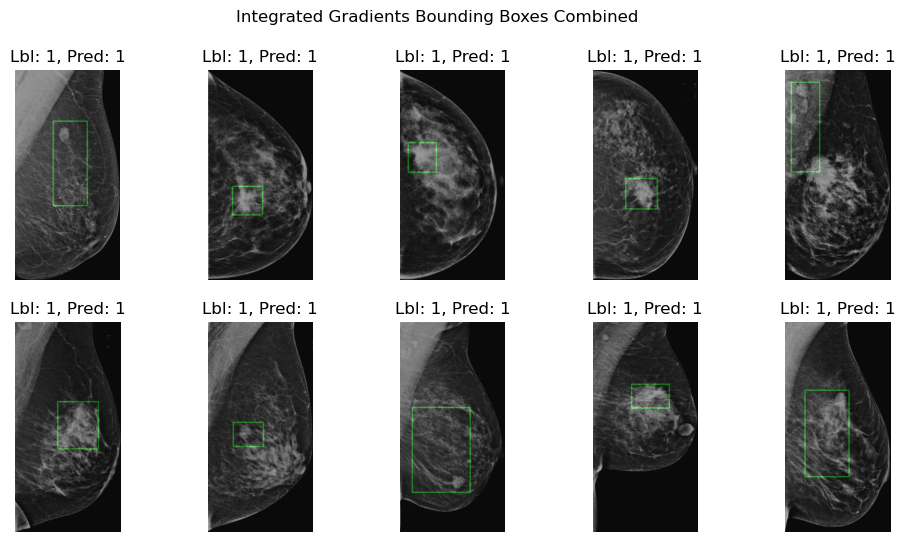

In [20]:
integrated_gradients = IntegratedGradients(model)
attributions_ig_list = []

for i in tqdm(range(len(input))):
    attributions_ig = integrated_gradients.attribute(input[i].unsqueeze(0), target=1, n_steps=50)
    attributions_ig = attributions_ig.squeeze(0).cpu().detach().numpy()
    attributions_ig_list.append(attributions_ig)

# DILATING RESULTS SO THEY'RE MORE VISIBLE
attributions_ig_list_dilated = dilate_attributions(attributions_ig_list)

# SHOWING THE RESULTS
show_attributions(attributions_ig_list, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.4, title='Integrated Gradients')
show_attributions(attributions_ig_list_dilated, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.4, title='Integrated Gradients Dilated')

############## BOUNDING BOXES ####################
# Binarize the attributions, find the bounding boxes, combine them into one for
# each image and draw them
binarized_attr_ig =    binarize_attributions(attributions_ig_list_dilated)
bbox_ig =              attr_bbox(binarized_attr_ig)
bbox_ig_combined =     combine_bbox(bbox_ig)
img_bbox_ig_combined = draw_bbox(bbox_ig_combined, np_imgs_exp)
show_bbox(img_bbox_ig_combined, np_imgs_exp, lbls_exp, pred_label_idxs, alpha_map=0.9, alpha_img=0.6, title='Integrated Gradients Bounding Boxes Combined')

############## COMPUTE IOU #######################
iou_ig = []
for i in range(len(bbox_ig_combined)):
    iou = calculate_iou(bbox_ig_combined[i], bbox_list_gt[i])
    iou_ig.append(iou)
print('IOU Scores: ')
print(iou_ig)

#### Occlusion

100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


[0.35583333333333333,
 0.24200581395348839,
 0.8094520656569661,
 0.6972783436299883,
 0.7187233524180777,
 0.4645277002789956,
 0.5575615284974094,
 0.4152777777777778,
 0.39131852603355194,
 0.7317376437674852]

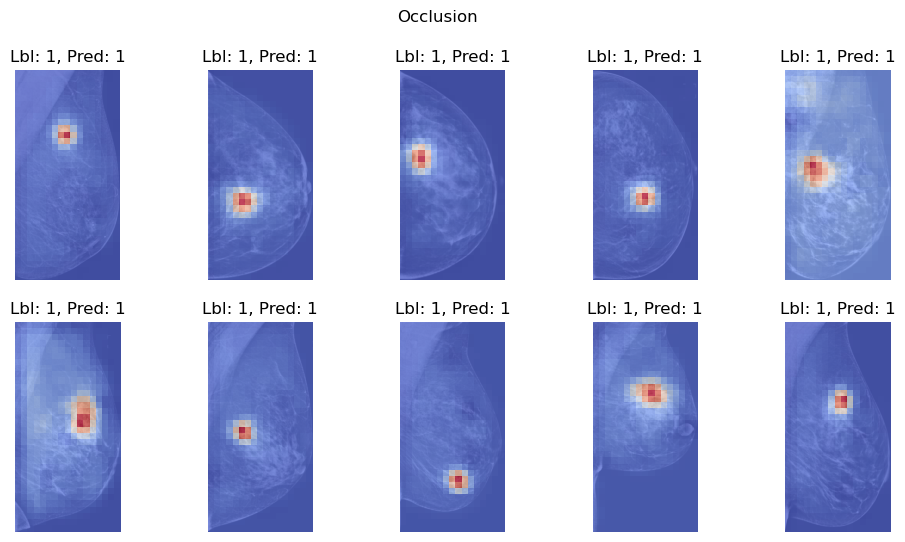

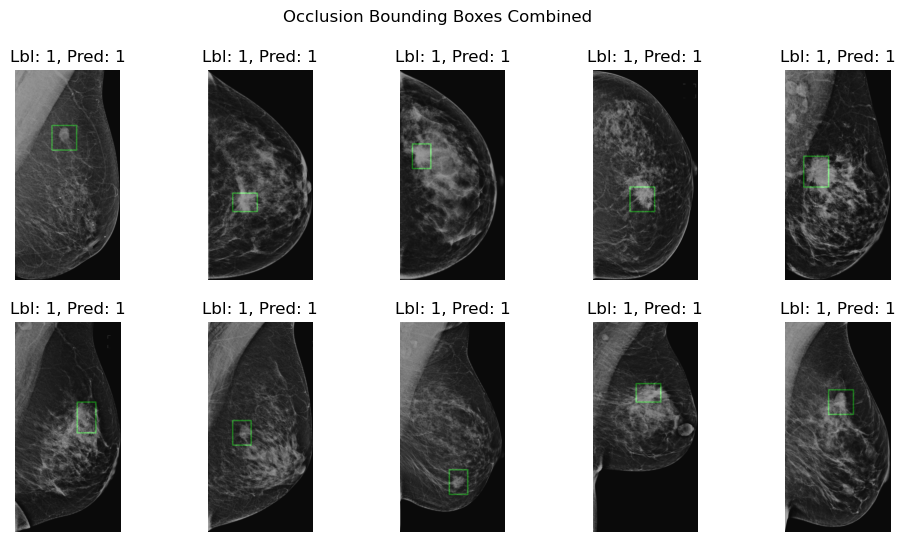

In [47]:
occlusion = Occlusion(model)
attributions_occ_list = []

for i in tqdm(range(len(input))):
    attributions_occ = occlusion.attribute(input[i].unsqueeze(0),
                                            strides = (3, 30, 30),
                                            target=1,
                                            sliding_window_shapes=(3, 60, 60),
                                            baselines=0)
    attributions_occ = attributions_occ.squeeze(0).cpu().detach().numpy()
    attributions_occ_list.append(attributions_occ)
    
# SHOWING THE RESULTS
show_attributions(attributions_occ_list, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='Occlusion')

############## BOUNDING BOXES ####################
# Binarize the attributions, find the bounding boxes, combine them into one for
# each image and draw them
binarized_attr_occ =    binarize_attributions(attributions_occ_list, 0.98)
bbox_occ =              attr_bbox(binarized_attr_occ)
bbox_occ_combined =     combine_bbox(bbox_occ)
img_bbox_occ_combined = draw_bbox(bbox_occ_combined, np_imgs_exp)
show_bbox(img_bbox_occ_combined, np_imgs_exp, lbls_exp, pred_label_idxs, alpha_map=0.9, alpha_img=0.6, title='Occlusion Bounding Boxes Combined')

############## COMPUTE IOU #######################
iou_occ = []
for i in range(len(bbox_occ_combined)):
    iou = calculate_iou(bbox_occ_combined[i], bbox_list_gt[i])
    iou_occ.append(iou)
print('IOU Scores: ')
print(iou_occ)

#### GradCAM

100%|██████████| 10/10 [00:00<00:00, 14.34it/s]


[0.4479020979020979,
 0.23201856148491878,
 0.5650165875235803,
 0.5267299375300336,
 0.11420762360290888,
 0.38385516879482245,
 0.7162458836443468,
 0.35348360655737704,
 0.3035617232508424,
 0.6937080112692335]

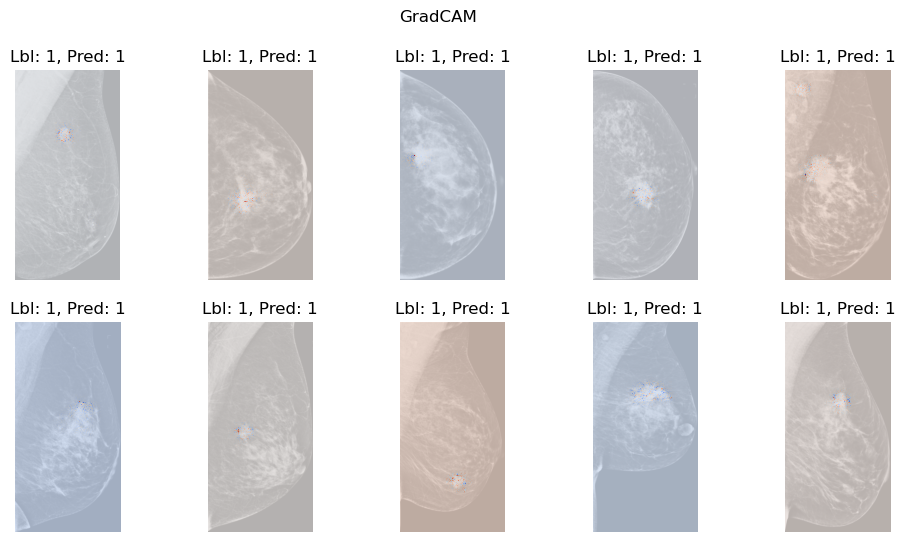

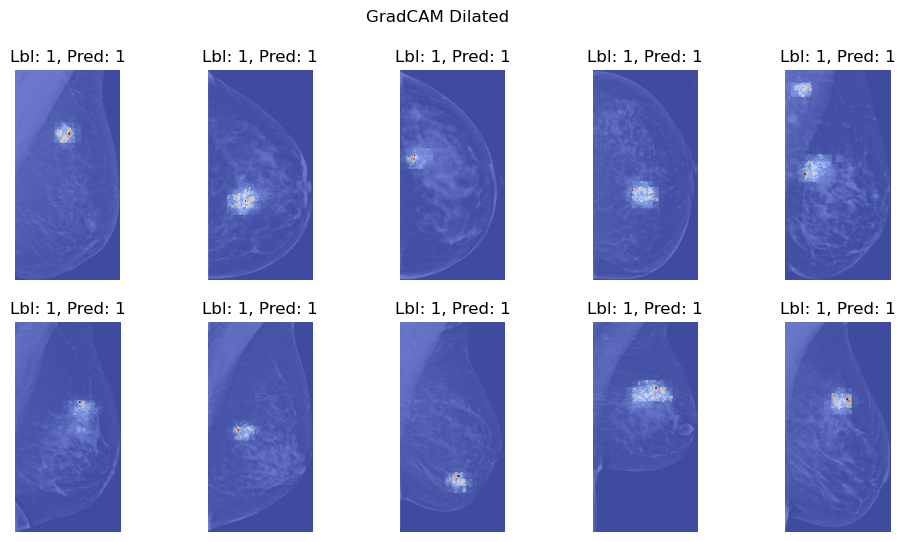

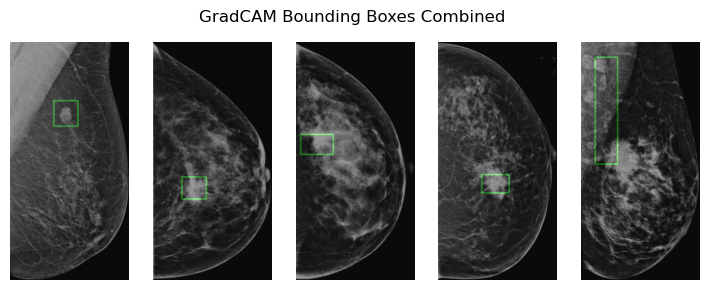

In [28]:
gradcam = GuidedGradCam(model, model.features[8])
attributions_gc_list = []
for i in tqdm(range(len(input))):
    attributions_gc = gradcam.attribute(input[i].unsqueeze(0), target=1)
    attributions_gc = attributions_gc.squeeze(0).cpu().detach().numpy()
    attributions_gc_list.append(attributions_gc)

# DILATING RESULTS SO THEY'RE MORE VISIBLE
attributions_gc_list_dilated = dilate_attributions(attributions_gc_list)

# SHOWING THE RESULTS
show_attributions(attributions_gc_list, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='GradCAM')
show_attributions(attributions_gc_list_dilated, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='GradCAM Dilated')

############## BOUNDING BOXES ####################
# Binarize the attributions, find the bounding boxes, combine them into one for
# each image and draw them
binarized_attr_gc =    binarize_attributions(attributions_gc_list_dilated, 0.98)
bbox_gc =              attr_bbox(binarized_attr_gc)
bbox_gc_combined =     combine_bbox(bbox_gc)
img_bbox_gc_combined = draw_bbox(bbox_gc_combined, np_imgs_exp)
show_bbox(img_bbox_gc_combined, np_imgs_exp, lbls_exp, pred_label_idxs, alpha_map=0.9, alpha_img=0.6, title='GradCAM Bounding Boxes Combined')

############## COMPUTE IOU #######################
iou_gc = []
for i in range(len(bbox_gc_combined)):
    iou = calculate_iou(bbox_gc_combined[i], bbox_list_gt[i])
    iou_gc.append(iou)
print(iou_gc)

#### LIME

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


[0.22158796056045668,
 0.2739841932196219,
 0.06068324948105407,
 0.4197965571205008,
 0.5061043285238623,
 0.21802258584927403,
 0.24985798144290855,
 0.21575342465753425,
 0.22464304070401525,
 0.21048261546445252]

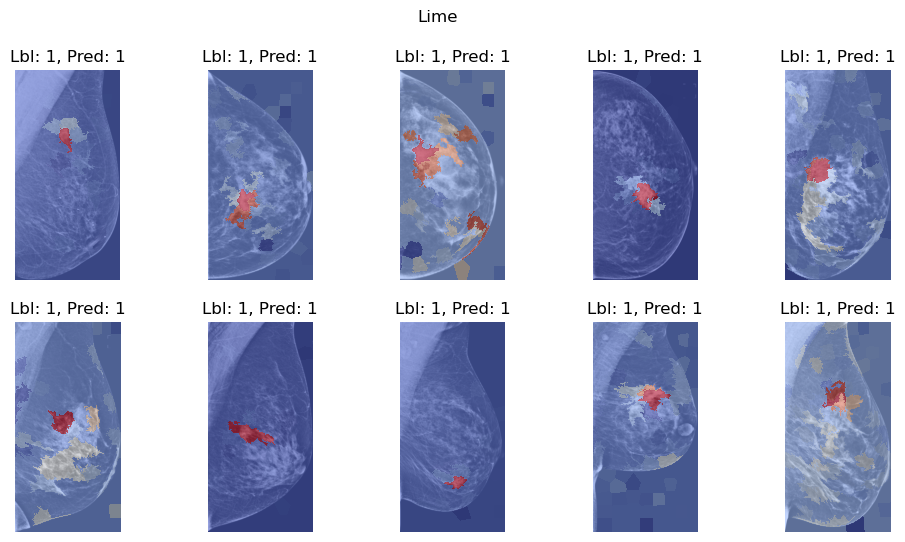

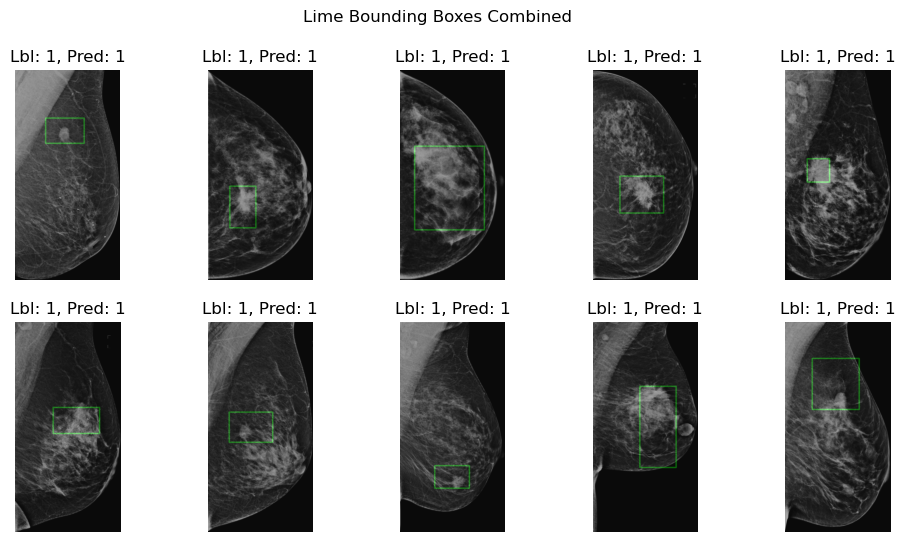

In [44]:
###### SEGMENT IMAGES FOR LIME AND SHAP
input_array = input.cpu().detach().numpy().transpose(0,2,3,1)
input_array.shape
mask_list = []
for i in range(input_array.shape[0]):
    mask = slic(input_array[i], n_segments=150, compactness=10)
    mask = mask - 1
    mask = torch.tensor(mask)
    mask_list.append(mask)
mask_list = [tensor.to(device) for tensor in mask_list]

##### COMPUTE LIME ATTRIBUTIONS
lime = Lime(model)
attributions_lime_list = []

for i in tqdm(range(len(input))):
    attributions_lime = lime.attribute(input[i].unsqueeze(0),
                                       feature_mask=mask_list[i],
                                       target=1,
                                       n_samples=200)
    attributions_lime = attributions_lime.squeeze(0).cpu().detach().numpy()
    attributions_lime_list.append(attributions_lime)

#### SHOW LIME ATTRIBUTIONS
show_attributions(attributions_lime_list, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.4, title='Lime')

############## BOUNDING BOXES ####################
# Binarize the attributions, find the bounding boxes, combine them into one for
# each image and draw them
binarized_attr_lime =    binarize_attributions(attributions_lime_list, 0.96)
bbox_lime =              attr_bbox(binarized_attr_lime)
bbox_lime_combined =     combine_bbox(bbox_lime)
img_bbox_lime_combined = draw_bbox(bbox_lime_combined, np_imgs_exp)
show_bbox(img_bbox_lime_combined, np_imgs_exp, lbls_exp, pred_label_idxs, alpha_map=0.9, alpha_img=0.6, title='Lime Bounding Boxes Combined')

############## COMPUTE IOU #######################
iou_lime = []
for i in range(len(bbox_lime_combined)):
    iou = calculate_iou(bbox_lime_combined[i], bbox_list_gt[i])
    iou_lime.append(iou)
print('IOU Scores: ')
print(iou_lime)

#### SHAP

100%|██████████| 10/10 [03:42<00:00, 22.20s/it]


[0.06062955289714629,
 0.24340796019900499,
 0.09742414476354175,
 0.08554845087940299,
 0.33317536668009384,
 0.2244485294117647,
 0.05836705052391327,
 0.042487186404100354,
 0.6410452089502121,
 0.46340361968944316]

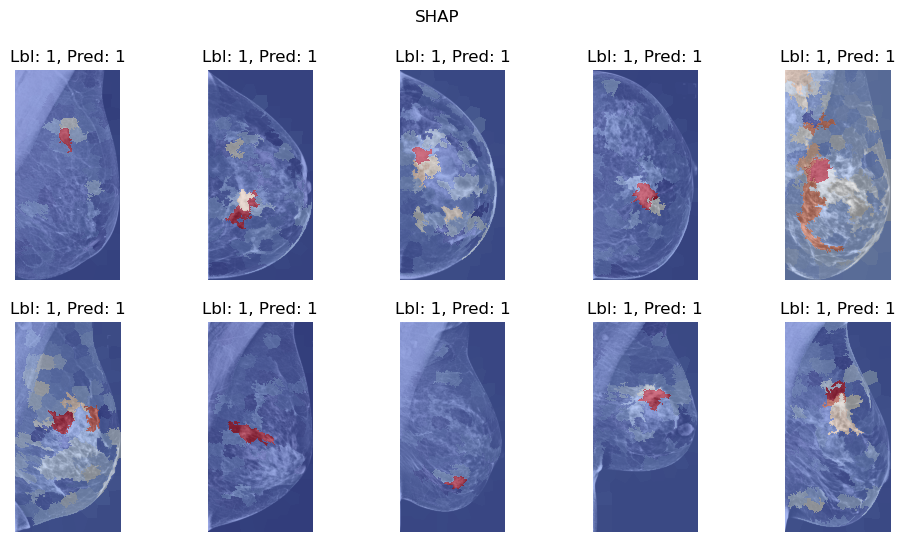

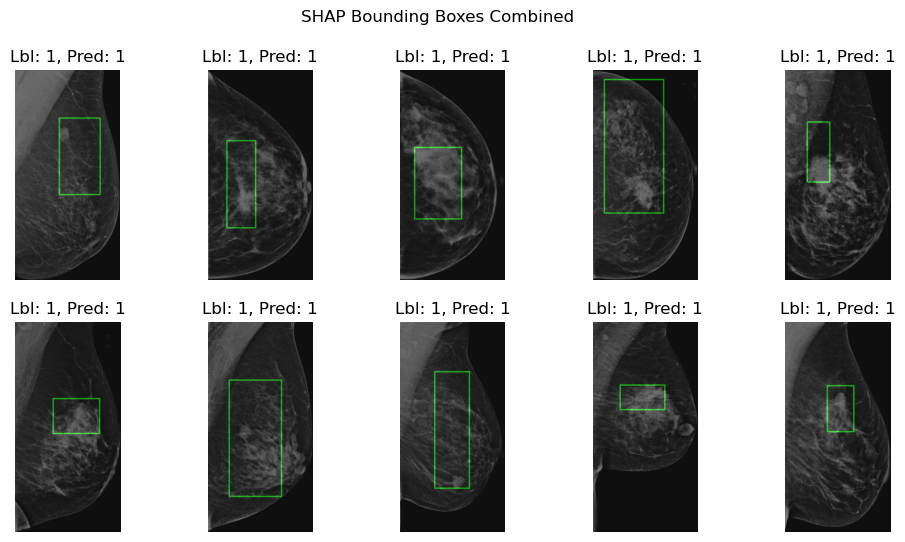

In [45]:
###### SEGMENT IMAGES FOR LIME AND SHAP
input_array = input.cpu().detach().numpy().transpose(0,2,3,1)
input_array.shape
mask_list = []
for i in range(input_array.shape[0]):
    mask = slic(input_array[i], n_segments=150, compactness=10)
    mask = mask - 1
    mask = torch.tensor(mask)
    mask_list.append(mask)
mask_list = [tensor.to(device) for tensor in mask_list]

svs = ShapleyValueSampling(model)
attributions_svs_list = []

for i in tqdm(range(len(input))):
    attributions_svs = svs.attribute(input[i].unsqueeze(0),
                                     feature_mask=mask_list[i],
                                     target=1,
                                     show_progress=True)
    attributions_svs = attributions_svs.squeeze(0).cpu().detach().numpy()
    attributions_svs_list.append(attributions_svs)

#### SHOW SHAP ATTRIBUTIONS
show_attributions(attributions_svs_list, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.4, title='SHAP')

############## BOUNDING BOXES ####################
# Binarize the attributions, find the bounding boxes, combine them into one for
# each image and draw them
binarized_attr_svs =    binarize_attributions(attributions_svs_list, 0.96)
bbox_svs =              attr_bbox(binarized_attr_svs)
bbox_svs_combined =     combine_bbox(bbox_svs)
img_bbox_svs_combined = draw_bbox(bbox_svs_combined, np_imgs_exp)
show_bbox(img_bbox_svs_combined, np_imgs_exp, lbls_exp, pred_label_idxs, alpha_map=0.9, alpha_img=0.4, title='SHAP Bounding Boxes Combined')

############## COMPUTE IOU #######################
iou_svs = []
for i in range(len(bbox_svs_combined)):
    iou = calculate_iou(bbox_svs_combined[i], bbox_list_gt[i])
    iou_svs.append(iou)
print('IOU Scores: ')
print(iou_svs)

#### DeepLIFT

  0%|          | 0/10 [00:00<?, ?it/s]Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
100%|██████████| 10/10 [00:00<00:00, 18.62it/s]


[0.05136121246140893,
 0.27578910245106686,
 0.6374878896677495,
 0.17659776992113135,
 0.08467208467208467,
 0.47995283018867924,
 0.12694275034428487,
 0.034050532964863794,
 0.19134108628424584,
 0.6135284616514121]

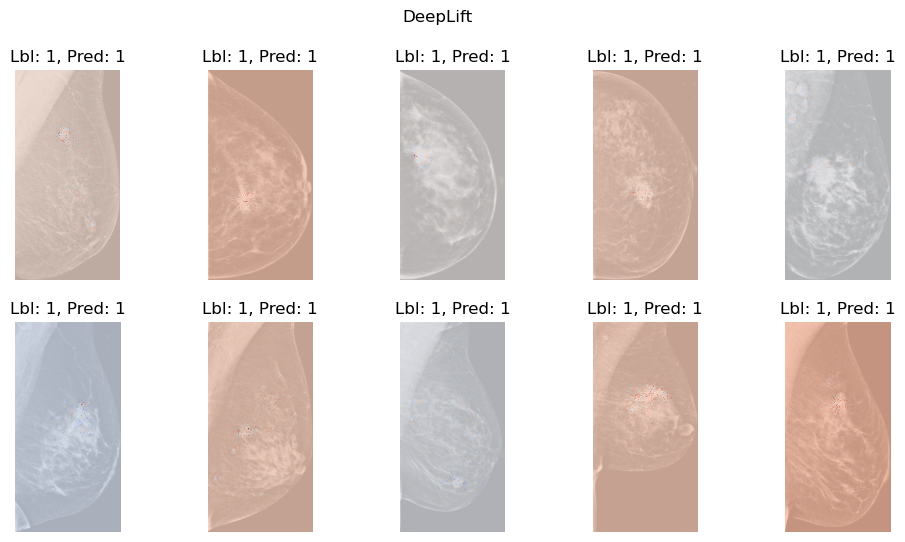

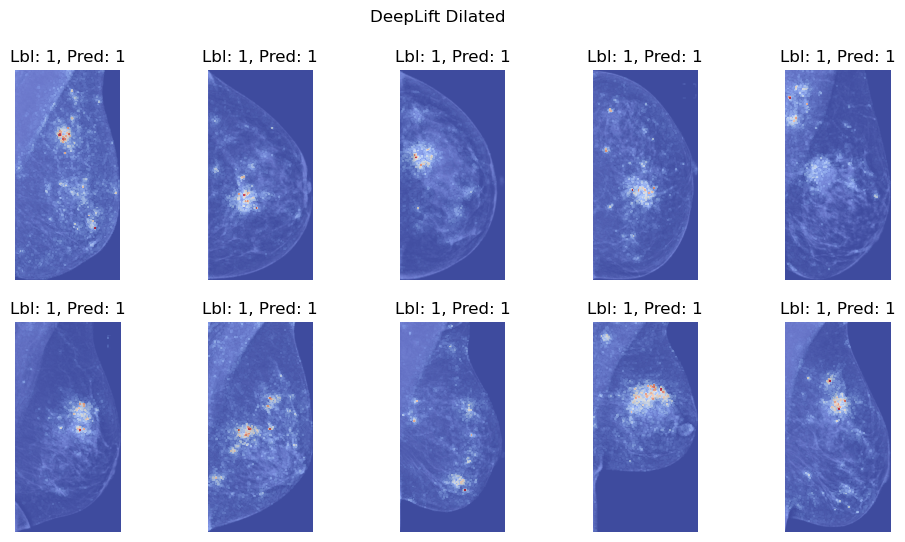

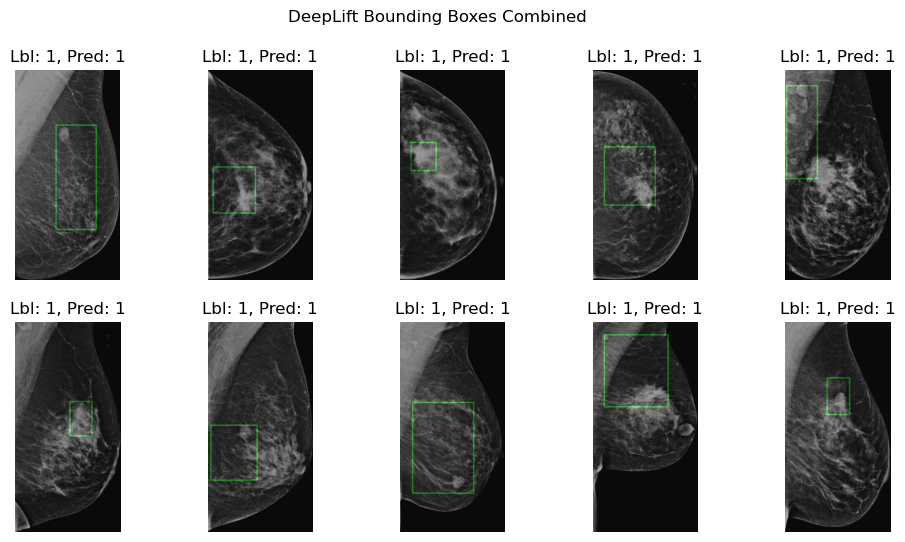

In [46]:
dl = DeepLift(model)
attributions_dl_list = []

for i in tqdm(range(len(input))):
    attributions_dl = dl.attribute(input[i].unsqueeze(0), target=1)
    attributions_dl = attributions_dl.squeeze(0).cpu().detach().numpy()
    attributions_dl_list.append(attributions_dl)

# DILATING RESULTS SO THEY'RE MORE VISIBLE
attributions_dl_list_dilated = dilate_attributions(attributions_dl_list)

# SHOWING THE RESULTS
show_attributions(attributions_dl_list, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='DeepLift')
show_attributions(attributions_dl_list_dilated, np_imgs_exp, lbls_exp, pred_label_idxs, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='DeepLift Dilated')

############## BOUNDING BOXES ####################
# Binarize the attributions, find the bounding boxes, combine them into one for
# each image and draw them
binarized_attr_dl =    binarize_attributions(attributions_dl_list_dilated, 0.96)
bbox_dl =              attr_bbox(binarized_attr_dl)
bbox_dl_combined =     combine_bbox(bbox_dl)
img_bbox_dl_combined = draw_bbox(bbox_dl_combined, np_imgs_exp)
show_bbox(img_bbox_dl_combined, np_imgs_exp, lbls_exp, pred_label_idxs, alpha_map=0.9, alpha_img=0.6, title='DeepLift Bounding Boxes Combined')

############## COMPUTE IOU #######################
iou_dl = []
for i in range(len(bbox_dl_combined)):
    iou = calculate_iou(bbox_dl_combined[i], bbox_list_gt[i])
    iou_dl.append(iou)
print('IOU Scores: ')
print(iou_dl)